<a href="https://colab.research.google.com/github/victoralcantara75/CNN-FLOWER-CLASSIFY/blob/master/CNN_FLOWER_CLASSIFY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CNN PARA CLASSIFICAÇÃO DE FLORES
## SIN493 - DEEP LEARNING PARA VISÃO COMPUTACIONAL

##PYTORCH E CUDA

In [0]:
#http://pytorch.org/

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [2]:
# verificando se o CUDA está disponível
GPUavailable = torch.cuda.is_available()

if GPUavailable:
    print('Treinamento em GPU!')
else:
    print('Treinamento em CPU!')

Treinamento em GPU!


##DATASET

In [3]:
import os
import numpy as np
import torch
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!unzip -qq flower_data.zip

replace flower_data/valid/61/image_06296.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:


diretorio_dados = 'flower_data'
diretorio_treino = diretorio_dados + '/train'
diretorio_validacao = diretorio_dados + '/valid'

In [0]:
# APLICANDO AS TRANSFORMACOES NECESSARIAS E O DATA AUGMENTATION

transformacao_treino = transforms.Compose([ 
                       transforms.RandomRotation(10),      #ROTAÇÃO DAS IMAGENS
                       transforms.RandomResizedCrop(224),  #INPUT SIZE 224X224
                       transforms.RandomHorizontalFlip(),  #ESPELHAMENTO
                       transforms.ToTensor(),
                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])
transformacao_validacao = transforms.Compose([ 
                          transforms.Resize(256),
                          transforms.CenterCrop(224),
                          transforms.ToTensor(),
                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])

In [8]:
dados_treino = datasets.ImageFolder(diretorio_treino, transformacao_treino)
dados_validacao = datasets.ImageFolder(diretorio_validacao, transformacao_validacao)

print('Numero de imagens de treino: ', len(dados_treino))
print('Numero de imagens de teste: ', len(dados_validacao))

Numero de imagens de treino:  6552
Numero de imagens de teste:  818


In [0]:
# Data Loaders e Visualização

batch_size = 20
num_workers=0

# dataloaders
treino_loader = torch.utils.data.DataLoader(dados_treino, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
validacao_loader = torch.utils.data.DataLoader(dados_validacao, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

In [0]:
#MAPEANDO OS LABELS
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

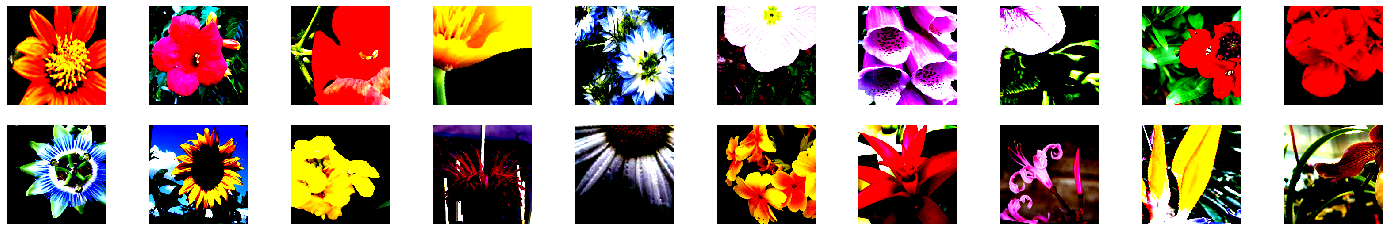

In [11]:
# obtendo um batch de imagens de treinamento
dataiter = iter(treino_loader)
images, labels = dataiter.next()
images = images.numpy() # para exibir as imagens converter para numpy

# plotar as imagens no batch, com os rótulos correspondentes
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))

##TREINO E CLASSIFICACAO VGG

In [0]:
import torchvision.models as models

#criando o modelo de vgg 16 pre treinada
VGG = models.vgg16(pretrained=True)
#visualizacao da arquitetura utilizada vgg16
VGG

# movendo os tensors para GPU se o CUDA estiver disponível
if GPUavailable:
    VGG.cuda()


In [0]:
# Congelar o treinamento para todas as camadas de características
for param in VGG.features.parameters():
    param.requires_grad = False

In [14]:
import torch.nn as nn

n_inputs = VGG.classifier[6].in_features

# adicionar a última camada linear(n_inputs -> 5 classes de flores)
# novas camadas automaticamente tem requires_grad = True
last_layer = nn.Linear(n_inputs, 102)

VGG.classifier[6] = last_layer

# se a GPU está disponível, mover o modelo para GPU
if GPUavailable:
    VGG.cuda()

# verifique se sua última camada produz o número esperado de saídas
print(VGG.classifier[6].out_features)
#print(vgg16)

102


In [0]:
import torch.optim as optim

# Especificando a loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# Definindo o Otimizador
optimizer = optim.SGD(VGG.parameters(), lr=0.01)

In [19]:
#TREINAMENTO 

epocas = 2

for epocas in range (1, epocas+1):

  treino_loss = 0.0
  
  VGG.train()
  for batch_i, (data, target) in enumerate(treino_loader):
        
        if GPUavailable:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = VGG(data)
        loss = criterion(output, target)  #batch loss
        loss.backward()
        optimizer.step()                  #otimizador SGD 
        treino_loss += loss.item()        #atualizacao do treinamento
        
        if batch_i % 20 == 19:
            print('Época %d, Batch %d loss: %.16f' %
                  (epocas, batch_i + 1, treino_loss / 20))
            treino_loss = 0.0
        
 

Época 1, Batch 20 loss: 3.4737859725952149
Época 1, Batch 40 loss: 3.1108770370483398
Época 1, Batch 60 loss: 2.7914765834808350
Época 1, Batch 80 loss: 2.4165127336978913
Época 1, Batch 100 loss: 2.2683425307273866
Época 1, Batch 120 loss: 1.9956727385520936
Época 1, Batch 140 loss: 1.9499927282333374
Época 1, Batch 160 loss: 1.7666398406028747
Época 1, Batch 180 loss: 1.6693764865398406
Época 1, Batch 200 loss: 1.8225781440734863
Época 1, Batch 220 loss: 1.6549444705247880
Época 1, Batch 240 loss: 1.7538134992122649
Época 1, Batch 260 loss: 1.5654252022504807
Época 1, Batch 280 loss: 1.3921461284160614
Época 1, Batch 300 loss: 1.4598261356353759
Época 1, Batch 320 loss: 1.4741383731365203
Época 2, Batch 20 loss: 1.3576944410800933
Época 2, Batch 40 loss: 1.3355234920978547
Época 2, Batch 60 loss: 1.1922838300466538
Época 2, Batch 80 loss: 1.2543058454990388
Época 2, Batch 100 loss: 1.2586003243923187
Época 2, Batch 120 loss: 1.1521611303091048
Época 2, Batch 140 loss: 1.1579563647508

In [20]:
#TESTE

test_loss = 0.0
class_correct = list(0. for i in range(102))
class_total = list(0. for i in range(102))

VGG.eval()

for data, target in validacao_loader:
    if GPUavailable:
        data, target = data.cuda(), target.cuda()
   
    output = VGG(data)
    loss = criterion(output, target)           #test loss
    test_loss += loss.item()*data.size(0)      #atualizando loss
    _, pred = torch.max(output, 1)    
    correct_tensor = pred.eq(target.data.view_as(pred))    #comparando respostas corretas
    correct = np.squeeze(correct_tensor.numpy()) if not GPUavailable else np.squeeze(correct_tensor.cpu().numpy())
   
    # calculando acurácia do teste
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

IndexError: ignored